In [1]:
import math 
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
import networkx as nx
from ortools.linear_solver import pywraplp as OR
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy
import pickle
from bokeh import palettes
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import (GraphRenderer, Circle, MultiLine, StaticLayoutProvider,
                          HoverTool, TapTool, EdgesAndLinkedNodes, NodesAndLinkedEdges,
                          ColumnDataSource, LabelSet, NodesOnly)
from matching import *
output_notebook()

Loading BokehJS ...

# Taxi Routing Bipartite Matching Lab

**Objectives:**

* Construct the taxi-routing problem as a bipartite graph.
* Use the maximum cardinality matching problem to solve the taxi-routing problem.
* Compare the original and optimal solutions to the taxi-routing problem.
    
<font color='red'> **Instructor Comments** </font>

<font color='blue'> **Solutions** </font>

**Introduction:**
....

## Part 1: Bipartite Graph Formulation 

Load the taxi trips information as well as NYC street nodes and arcs.

In [2]:
trips_df = pd.read_csv('data/2013-09-01_trip_data_manhattan.csv').drop(columns='id')
nodes_df = pd.read_csv('data/nyc_nodes_manhattan.csv').drop(columns='Unnamed: 0')
arcs_df = pd.read_csv('data/nyc_links_manhattan.csv').drop(columns='Unnamed: 0')
with open('data/time_map.pkl', 'rb') as f:
    times = pickle.load(f) # A dictionary with dropoff-pickup pairs as keys and travel times as values

Look at an example input. Each trip consists of ...

In [3]:
# A list of example trip_ids
ex_trips = [81247, 82007, 81152, 81954, 82250, 81855, 81114, 81090, 82851, 82629]
# Locate the corresponding trip information
trips = trips_df.iloc[ex_trips]
trips

,medallion,hack_license,start_node,end_node,start_time,trip_time,passenger_count,trip_distance
81247,2013001856,2013001853,2588,1314,1021,2,2,1.448406
82007,2013011673,2013017918,1312,158,1028,7,1,3.411801
81152,2013010971,2013019660,2010,1312,1020,6,1,3.218680
81954,2013006495,2013039633,889,752,1028,2,1,0.643736
82250,2013003369,2013003365,581,1597,1030,4,6,0.981697
81855,2013005742,2013028475,46,1796,1027,6,1,1.770274
81114,2013004062,2013032693,590,305,1020,4,1,1.689807
81090,2013009049,2013016486,586,581,1020,3,1,0.836857
82851,2013006431,2013032798,1796,480,1035,4,5,1.721994
82629,2013009933,2013033254,751,2670,1033,14,2,5.133795


Construct nodes and edges

In [4]:
# Intialize nodes and edges
DO_nodes = list()
PU_nodes = list()
edges = list()
# Initialize a dict that maps a PU node to a DO node
PUtoDO = dict()

Each node is a tuple of (location_id, time, trip_id, "DO"/"PU")

In [5]:
for index, row in trips.iterrows():
    s = row['start_node']
    t = row['end_node']
    s_t = row['start_time']
    t_t = s_t + row['trip_time']
    DO_node = (int(t), t_t, index, 'DO')
    PU_node = (int(s), s_t, index, 'PU')
    DO_nodes.append(DO_node)
    PU_nodes.append(PU_node)
    PUtoDO[PU_node] = DO_node

**Q:** Assume that a taxi handles two consecutive trips $i$ and $j$ (in order), where the drop-off time at location $d_i$ is $T^d_i$ and the pickup time at location $p_j$ is $T^p_j$. What is the *elapsed time* between the drop-off time of trip $i$ and the pickup time of trip $j$ (express in terms of $T^d_i$ and $T^p_j$) ?

**A:** <font color='blue'> The *elapsed time* is $T^p_j - T^d_i$.</font>

**Q:** Assume that $time(d_i, p_j)$ is the time needed to travel between location point $d_i$ and location point $p_j$. What relationship must hold between the *elasped time* between the drop-off time of trip $i$ and the pickup time of trip $j$ and $time(d_i, p_j)$ in order for a taxi to cover both trip $i$ and trip $j$ (express in terms of $time(d_i, p_j), T^d_i$ and $T^p_j$)? What does your inequality mean?

**A:** <font color='blue'> $time(d_i, p_j) \leq T^p_j - T^d_i$. It means that a taxi can reach the new pickup at $p_j$ in time after dropping off the fare at $d_i$. </font>

Max waiting time...

In [6]:
# Sort the nodes by time
DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
PU_nodes = sorted(PU_nodes, key = lambda x: x[1])

# Specify edges
max_waiting_time = 10

for DO_node in DO_nodes:
    for PU_node in PU_nodes:
        if PU_node[1] > DO_node[1] + max_waiting_time:
            break
        else:
            if PU_node[1] >= DO_node[1]:
                time = times[(DO_node[0], PU_node[0])]
                if ((PU_node[1] - DO_node[1]) - max_waiting_time  <= time) & (time <= (PU_node[1] - DO_node[1])):
                    edges.append((DO_node, PU_node))

Generate the bipartite graph

In [7]:
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(DO_nodes, bipartite=0)
B.add_nodes_from(PU_nodes, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(edges)

Obtain the maximum cardinality matching.

In [8]:
match = nx.bipartite.maximum_matching(B, DO_nodes)
print('size of max cardinality matching:', int(len(match)/2)) # divided by two because the output edges are directed

size of max cardinality matching: 6


**Q:** What is the minimum number of taxis needed to cover all the trips according to the maximum cardinality matching?

**A:** <font color='blue'> 4 taxis.</font>

We can use the information given by maximum cardinality matching to track down the optimal taxi trajectories. 

In [9]:
opt_paths = match_to_path(match, trips)

Plot the bipartite graph

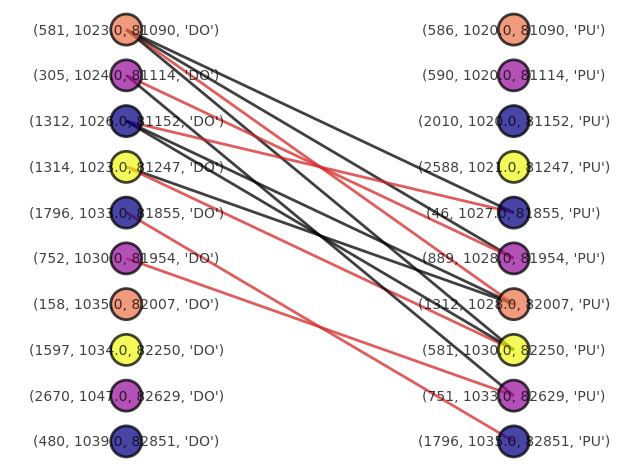

In [10]:
plot_ex_bipartite(B, match, opt_paths, True)

**Q:** Interpret one optimal taxi trajectory based on the graph above using the location ids (remember each node is a tuple of (location_id, time, trip_id, "DO"/"PU")).

**A:** <font color='blue'> 586->581->1597 or 590->305->889->752->751 or 2010->1312->46->1796->480 or 2588->1314->1312->158 </font>

Plot the corresponding taxi paths on the map

In [11]:
G = street_network(nodes_df, arcs_df)
plot_taxi_route(G, opt_paths, nodes_df)

## Part 2: Bipartite Graph Formulation (At Scale)

Now, instead of selecting a sample selection of taxi trips, try filter the trips by time window of interest. The following example selects all the trips from 5 pm to 5:15 pm.

In [12]:
# Filter trips by time window of interest
start_time = 1020
end_time = 1035
trips = trips_df.copy()
trips = trips[(trips.start_time >= start_time) & 
              (trips.start_time + trips.trip_time <= end_time)].copy()
trips.start_time = trips.start_time - start_time

Nodes and edges are defined similarly.

In [13]:
# Intialize nodes and edges
DO_nodes = list()
PU_nodes = list()
edges = list()
# Initialize a dict that maps a PU node to a DO node
PUtoDO = dict()

In [14]:
# Specify nodes - each node is a tuple of (location_id, time, trip_id, "DO"/"PU")
for index, row in trips.iterrows():
    s = row['start_node']
    t = row['end_node']
    s_t = row['start_time']
    t_t = s_t + row['trip_time']
    DO_node = (int(t), t_t, index, 'DO')
    PU_node = (int(s), s_t, index, 'PU')
    DO_nodes.append(DO_node)
    PU_nodes.append(PU_node)
    PUtoDO[PU_node] = DO_node

In [15]:
# Sort the nodes by time
DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
PU_nodes = sorted(PU_nodes, key = lambda x: x[1])

# Specify edges
max_waiting_time = 10

for DO_node in DO_nodes:
    for PU_node in PU_nodes:
        if PU_node[1] > DO_node[1] + max_waiting_time:
            break
        else:
            if PU_node[1] >= DO_node[1]:
                time = times[(DO_node[0], PU_node[0])]
                if ((PU_node[1] - DO_node[1]) - max_waiting_time  <= time) & (time <= (PU_node[1] - DO_node[1])):
                    edges.append((DO_node, PU_node))

In [16]:
# load the model
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(DO_nodes, bipartite=0)
B.add_nodes_from(PU_nodes, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(edges)

In [17]:
match = nx.bipartite.maximum_matching(B, DO_nodes)

In [18]:
print('size of max cardinality matching:', len(match) / 2)

size of max cardinality matching: 148.0


In [19]:
# Calculate number of unmatched nodes (minimum number of taxis needed)
# TODO: Assign num_taxi with the minimum number of taxis needed
# num_taxi = XXX

### BEGIN SOLUTION
num_taxi = len(DO_nodes) - len(match)/2
### END SOLUTION

print('min number of taxis needed: ', num_taxi)

min number of taxis needed:  644.0


The maximum matching problem can also be formulated via an IP formulation.
$$\begin{align*}
\min \quad & \sum_{e \in E}x_e \\
\text{s.t.} \quad &  \sum_{e \in \delta(v)} x_e \leq 1 \quad \forall v \in P \cup D & (1)\\
\quad & x_e \in \{0,1\} \quad \forall e \in E & (2)\\
\end{align*}$$

where, $\delta(v)$ is the set of edges incident on the vertex $v \in P \cup D$.

In [20]:
# A dictionary that stores the list of edges adjacent to node
incident = dict()
for v in (DO_nodes + PU_nodes):
    incident[v] = [edge for edge in edges if v in edge]

In [21]:
solver = OR.Solver('taxi_bipartite', OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
# Decision variables
x = {}  
for e in edges:
    x[e] = solver.IntVar(0, 1, ('(%s)' % str(e)))

solver.Maximize(sum(x[e] for e in edges))

for v in (DO_nodes + PU_nodes):
    if v in incident.keys():
        solver.Add(sum(x[e] for e in incident[v]) <= 1)

In [22]:
solver.Solve()
print('Solution:')
print('Objective value =', solver.Objective().Value())

Solution:
Objective value = 148.0


We can also check our answer by reducing the max matching problem to a max flow problem - the max flow value should be equal to the size of max cardinality matching.

In [23]:
G = nx.DiGraph()
G.add_nodes_from(PU_nodes + DO_nodes + ['s'] + ['t'])
for edge in edges:
    G.add_edge(edge[0], edge[1], capacity = 1)
for DO_node in DO_nodes:
    G.add_edge('s', DO_node, capacity = 1)
for PU_node in PU_nodes:
    G.add_edge(PU_node, 't', capacity = 1)

In [24]:
flow_value, flow_dict = nx.maximum_flow(G, "s", "t")

In [25]:
print('max flow value: ', flow_value)

max flow value:  148


In [26]:
# Try another alogrithm to solve max flow
from networkx.algorithms.flow import shortest_augmenting_path
print('max flow value: ', nx.maximum_flow(G, "s", "t", flow_func=shortest_augmenting_path)[0])

max flow value:  148


Turn this into a function

In [27]:
def max_match(start_time, end_time, trips_df, max_waiting_time):
    # filter trips by time window of interest
    trips = trips_df.copy()
    trips = trips[(trips.start_time >= start_time) & 
                  (trips.start_time + trips.trip_time <= end_time)].copy()
    trips.start_time = trips.start_time - start_time

    # create a dictionary to map the location pairs to trip time
    loc_time = dict()
    for index, row in arcs_df.iterrows():
        i = row['start']
        j = row['end']
        delay = row['trip_time']
        loc_time[(i, j)] = delay
    # Intialize nodes and edges
    DO_nodes = list()
    PU_nodes = list()
    edges = list()
    # Initialize a dict that maps a PU node to a DO node
    PUtoDO = dict()
    # Specify nodes - each node is a tuple of (location_id, time, trip_id, "DO"/"PU")
    for index, row in trips.iterrows():
        s = row['start_node']
        t = row['end_node']
        s_t = row['start_time']
        t_t = s_t + row['trip_time']
        DO_node = (int(t), t_t, index, 'DO')
        PU_node = (int(s), s_t, index, 'PU')
        DO_nodes.append(DO_node)
        PU_nodes.append(PU_node)
        PUtoDO[PU_node] = DO_node
    DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
    PU_nodes = sorted(PU_nodes, key = lambda x: x[1])
    
    # Specify edges
    for DO_node in DO_nodes:
        for PU_node in PU_nodes:
            if PU_node[1] > DO_node[1] + max_waiting_time:
                break
            else:
                if PU_node[1] >= DO_node[1]:
                    time = times[(DO_node[0], PU_node[0])]
                    if ((PU_node[1] - DO_node[1]) - max_waiting_time <= time) & (time <= (PU_node[1] - DO_node[1])):
                        edges.append((DO_node, PU_node))
    
    # load the model
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(DO_nodes, bipartite=0)
    B.add_nodes_from(PU_nodes, bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(edges)
    
    top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    match = nx.bipartite.maximum_matching(B, top_nodes)
    num_taxi = len(DO_nodes) - len(match)/2

    return match, num_taxi

In [28]:
match, num_taxi = max_match(1020, 1035, trips_df, 10)
print('max cardinality matching:', len(match)/2)
print('min number of taxis needed to cover all trips:', num_taxi)

max cardinality matching: 148.0
min number of taxis needed to cover all trips: 644.0


Try expanding the time window to 5-6 pm and restrict the max waiting time to 5 mininutes.

In [29]:
match = max_match(1020, 1080, trips_df, 5)
print('max cardinality matching:', len(match)/2)
print('min number of taxis needed to cover all trips:', num_taxi)

max cardinality matching: 1.0
min number of taxis needed to cover all trips: 644.0


## Part 3: Compare one day's taxi routing solutions

In [30]:
# Load the result of a day's data
with open('data/day_match.pkl', 'rb') as f:
    match = pickle.load(f)

In [31]:
# Get the optimal taxi paths
opt_paths = match_to_path(match, trips_df)

In [32]:
# Construct the street network
G = street_network(nodes_df, arcs_df)

In [33]:
# Select all the routes with more than 1 trip
opt_paths2 = []
for path in opt_paths:
    if len(path) > 1:
        opt_paths2.append(path)

In [34]:
plot_taxi_route(G, opt_paths2[:5], nodes_df,'Optimal Sample Taxi Routes')

Retrieve the original paths of the taxis

In [35]:
og_paths = get_og_path(trips_df)

In [36]:
# Select all the routes with more than 1 trip
og_paths2 = []
for path in og_paths:
    if len(path) > 1:
        og_paths2.append(path)

In [37]:
plot_taxi_route(G, og_paths2[:5], nodes_df,'Original Sample Taxi Routes')

Compare statistics of the taxi routings

In [38]:
opt_stats = get_taxi_stats(opt_paths, trips_df)
og_stats = get_taxi_stats(og_paths, trips_df)

Summary statistics for the original taxi routing

In [39]:
agg_stats(og_stats)

Summary Statistics
Total Taxis:  11569
Avg. Moving Pct.: 1.00
Avg. On Trip Pct.: 0.17
Avg. Total Trip Time: 16.18 hr
Avg. Empty Trip Time: 14.35 hr
Avg. Number of Trips: 11.36


Summary statistics for the optimal taxi routing

In [40]:
agg_stats(opt_stats)

Summary Statistics
Total Taxis:  8429
Avg. Moving Pct.: 0.99
Avg. On Trip Pct.: 0.76
Avg. Total Trip Time: 3.71 hr
Avg. Empty Trip Time: 1.21 hr
Avg. Number of Trips: 15.60


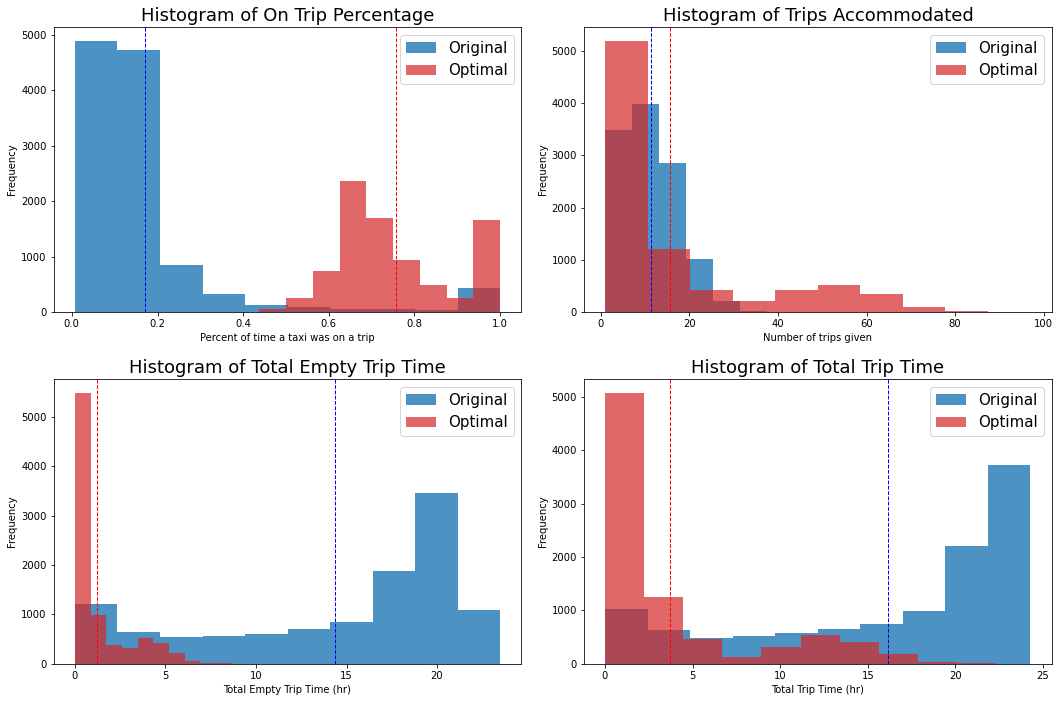

In [41]:
plot_stats(og_stats, opt_stats)

Another way to compare different taxi routings is to compare their distribution of taxis over time.

In [42]:
day_data = get_day_dist(og_paths, opt_paths, times)

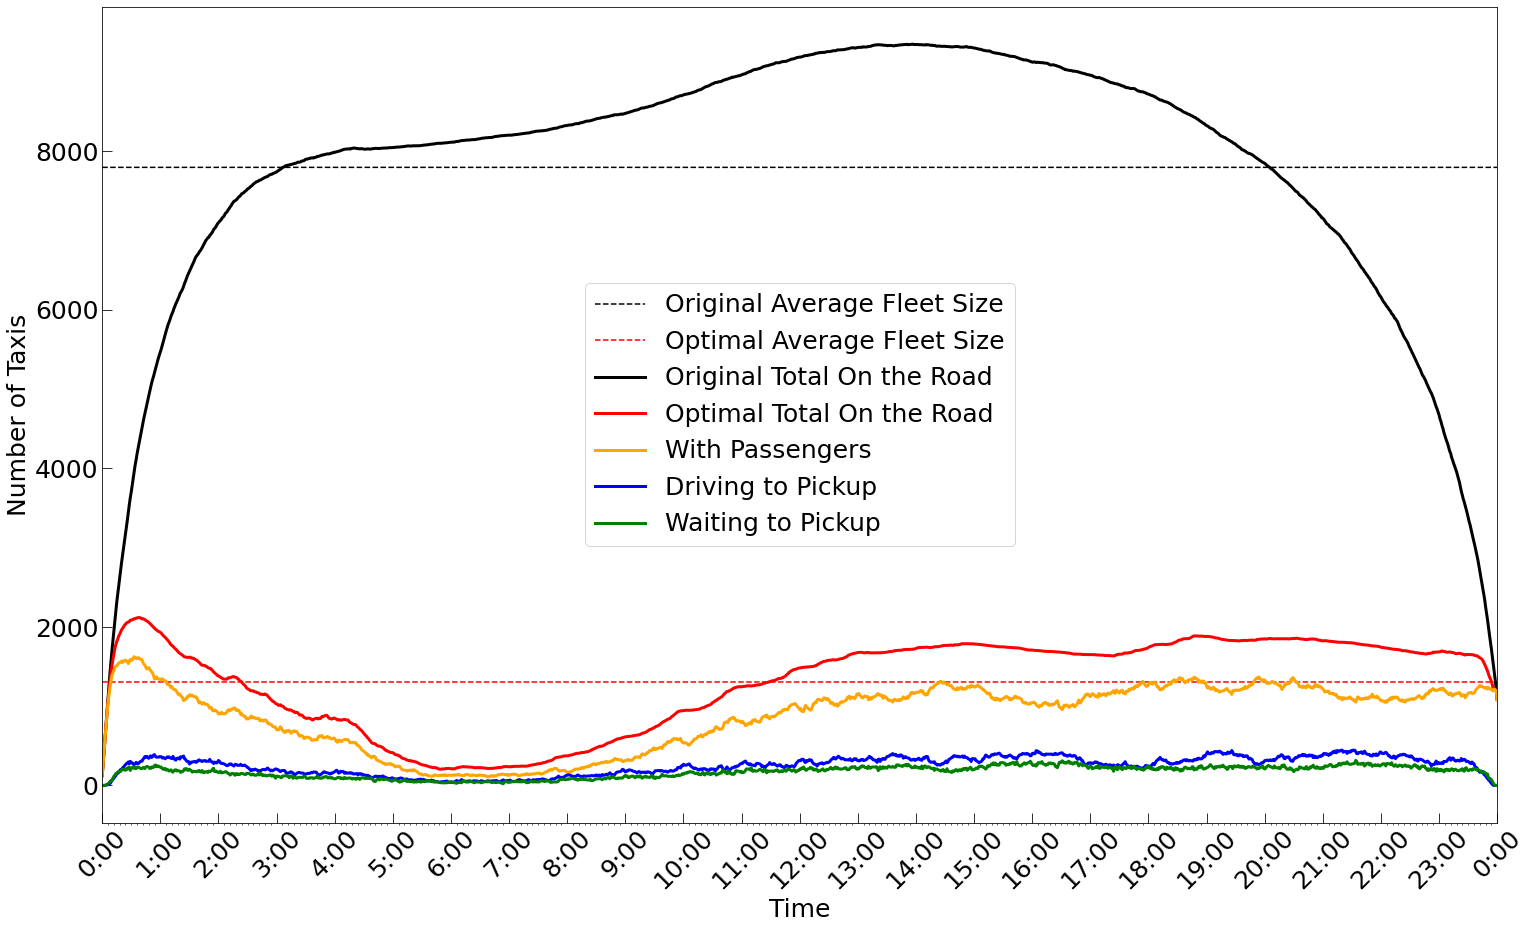

In [43]:
plot_taxi_dist(day_data)

In [44]:
num_circulating(day_data)

original number of circulating taxis:  7798
optimal number of circulating taxis:  1305
